In [ ]:
## added code for checking validation set and graph plot.

In [ ]:
from sklearn import metrics
import tensorflow as tf
import csv
from threading import Thread
from matplotlib import pyplot as plt
% matplotlib inline
from  read_proces_data import *

In [2]:
sess = tf.InteractiveSession()

In [3]:
# create lstm cell in tensorflow
hidden_units = 128
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units =\
        hidden_units,state_is_tuple=True)

batch_size = 20
max_seq = 3260
feature_vec_len = 57
x = tf.placeholder(tf.float32, shape = [batch_size,max_seq,feature_vec_len])
s_len = tf.placeholder(tf.int32,shape=[batch_size])
# run lstm over different sequence length
output_, state = tf.nn.dynamic_rnn(\
        lstm_cell,\
        x,\
#        initial_state = i_state,\
        sequence_length=s_len,\
        dtype=tf.float32)
# take all batch, last output of each batch and full output vector
def take_subarray(array , index):
    return array[range(0,batch_size),index-1]
output = tf.py_func(take_subarray,[output_,s_len],tf.float32)
#print output
# define final output value
target_value = tf.placeholder(tf.float32, shape=[batch_size])
# define weights and bias from output of lstm cell to network final output
rv1 = tf.truncated_normal([lstm_cell.output_size, 2 * lstm_cell.output_size],\
        stddev=0.1,dtype=tf.float32)
Wo1 = tf.Variable(rv1,dtype=tf.float32)

rv2 = tf.truncated_normal([2 * lstm_cell.output_size, 1],\
        stddev=0.1,dtype=tf.float32)
Wo2 = tf.Variable(rv2,dtype=tf.float32)

rb1 = tf.constant(0.1,shape=[2 * lstm_cell.output_size],dtype=tf.float32)
b1 = tf.Variable(rb1,dtype=tf.float32)

rb2 = tf.constant(0.1,shape=[1],dtype=tf.float32)
b2 = tf.Variable(rb2,dtype=tf.float32)
# initialize variables
# calculate final output

s1  = tf.matmul(output, Wo1) + b1
o1 = tf.nn.relu(s1)
logits  = tf.matmul(o1, Wo2) + b2
observed = tf.sigmoid(logits)
#observed = tf.nn.relu(logits)

# calculate cost as calculated in logistic classification.
logistic_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels = target_value, logits = tf.reshape(logits,[batch_size])))
#cost = tf.reduce_mean(-1.0 * target_value * tf.log(observed) - \
#        (1 - target_value) * tf.log(1 - observed))
#cost = tf.reduce_mean(-1 * target_value * tf.log(observed))
#cost = tf.reduce_mean(tf.square(target_value - observed))
# optimize the cost
train_step = tf.train.AdamOptimizer(1e-4).minimize(logistic_cost)
def threshold_fn(array):
    return array >= 0.50
obser = tf.py_func(threshold_fn,[observed], tf.bool)
observe = tf.cast(obser,tf.float32)

sess.run(tf.global_variables_initializer())

In [4]:
# find max no of times to roll back
#max_seq_len = find_max_seq_len()
#print max_seq_len
max_seq_len = 3259

In [5]:
inde_featuress = []
sseq_len = []
target_valuess = []
def data_processing(file_name):
    # get features from current indexed file
    features = get_train_data(file_name)
    # get target values corresponding to this file
    target_valuess.append(get_target_values(file_name))
    # training features is np array with max size and padding
    training_features, s_l = prepare_data(features, max_seq_len)
    sseq_len.append(s_l)
    # scale features to have 0 mean and 1 variance
    scaled_features = feature_scaling(training_features, batch_size,\
            s_l)
    # check if there is any NaN or Inf entries in data
    #isnan = np.any(np.isnan(scaled_features))
    #if True == isnan:
    #    print "nan entry found for file %s"%file_
    #isinf = np.any(np.isinf(scaled_features))
    #if True == isinf:
    #    print "inf entry found for file %s"%file_
    # find independent components from given features
    inde_featuress.append(independent_components(scaled_features, batch_size,\
            s_l))

In [6]:
def file_evaluate(data):
    # evaluate over whole file
    y = np.zeros(0)
    if "Sess05" in data[0]:
#                print file_
#                print inde_features.shape
        for index in range(0,100,batch_size):
#                    print inde_features[index:index+batch_size].shape                    
            #print inde_features.shape
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][0][index:index+batch_size], \
                s_len:data[2][0][index:index+batch_size]})
            y = np.append(y,yfile)
    else:
        for index in range(0,60,batch_size):
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][0][index:index+batch_size], \
                s_len:data[2][0][index:index+batch_size]})
            y = np.append(y,yfile)

    f1score = metrics.f1_score(data[3][0],y)
#    print "f1-score of file is %f"%f1score
    fprr, tprr, thresholds = metrics.roc_curve(data[3][0], y, pos_label=1)
    aucc = metrics.auc(fprr,tprr)
#    print "area under curve of file is %f"%aucc
    sk_acc = metrics.accuracy_score(data[3][0],y)
#    print "accuracy of file is %f"%sk_acc
#    print " "
    return (f1score, aucc, sk_acc)

In [7]:
def train_eval(train_data, val_data):
    for i in range(0,10):
        tr_fe, sl , tv =\
        sample_data(train_data[1][0],train_data[3][0],train_data[2][0],batch_size)

        sess.run(train_step, feed_dict = {target_value:tv,\
                x:tr_fe, s_len:sl})

        if i%8 == 0:
            print "iteration %d"%i
            print "cost %f"%sess.run(logistic_cost, feed_dict = {target_value:tv,\
                x:tr_fe, s_len:sl})

#            y = sess.run(observe, feed_dict = {x:tr_fe, s_len:sl})            
#            f1s = metrics.f1_score(tv,y)
#            print "f1-score is %f"%f1s
#            fpr, tpr, thresholds = metrics.roc_curve(tv, y, pos_label=1)
#            auc = metrics.auc(fpr,tpr)
#            print "area under curve is %f"%auc
#            sk_accuracy = metrics.accuracy_score(tv,y)
#            print "accuracy %f"%sk_accuracy
            # collect values to print graph later
            t_f1s, t_auc, t_acc = file_evaluate(train_data)
            train_para.append([t_f1s, t_auc, t_acc])
            # collect values to print graph later
            v_f1s, v_auc, v_acc = file_evaluate(val_data)
            vali_para.append([v_f1s, v_auc, v_acc])

In [ ]:
def plot_parameters(training_p, validation_p):
    nu_para = training_p.shape[1]
    para_name = ['f1score','auc','accuracy']
    for j in range(nu_para):
        plt.subplot(nu_para,1,j+1)
        plt.plot(training_p[:,j])
        plt.plot(validation_p[:,j])
        plt.ylabel(para_name[j])
    plt.show()

iteration 0
cost 0.698835
 
 
iteration 8
cost 0.696217
 
 
iteration 0
cost 0.695505
 
 
iteration 8
cost 0.695306
 
 
iteration 0
cost 0.694514
 
 
iteration 8
cost 0.694201
 
 
iteration 0
cost 0.692589
 
 
iteration 8
cost 0.693145
 
 
iteration 0
cost 0.694164
 
 
iteration 8
cost 0.692099
 
 
iteration 0
cost 0.696179
 
 
iteration 8
cost 0.692823
 
 
iteration 0
cost 0.693575
 
 
iteration 8
cost 0.693907
 
 
iteration 0
cost 0.691479
 
 
iteration 8
cost 0.691055
 
 
iteration 0
cost 0.692349
 
 
iteration 8
cost 0.692477
 
 
iteration 0
cost 0.693582
 
 
iteration 8
cost 0.693221
 
 
iteration 0
cost 0.693698
 
 
iteration 8
cost 0.692949
 
 
iteration 0
cost 0.690735
 
 
iteration 8
cost 0.693120
 
 
iteration 0
cost 0.694016
 
 
iteration 8
cost 0.694258
 
 
iteration 0
cost 0.693547
 
 
iteration 8
cost 0.693646
 
 
iteration 0
cost 0.693609
 
 
iteration 8
cost 0.692577
 
 
iteration 0
cost 0.692810
 
 
iteration 8
cost 0.693300
 
 
iteration 0
cost 0.693803
 
 
iteration 

/home/gnl/TF/local/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


 
 
iteration 0
cost 0.693483
 
 
iteration 8
cost 0.693107
 
 
iteration 0
cost 0.692791
 
 
iteration 8
cost 0.693102
 
 
iteration 0
cost 0.694180
 
 
iteration 8
cost 0.693761
 
 
iteration 0
cost 0.691780
 
 
iteration 8
cost 0.693906
 
 
iteration 0
cost 0.692241
 
 
iteration 8
cost 0.693253
 
 
iteration 0
cost 0.692802
 
 
iteration 8
cost 0.692994
 
 
iteration 0
cost 0.693150
 
 
iteration 8
cost 0.692575
 
 
iteration 0
cost 0.693312
 
 
iteration 8
cost 0.692975
 
 
iteration 0
cost 0.691927
 
 
iteration 8
cost 0.692314
 
 
iteration 0
cost 0.691343
 
 
iteration 8
cost 0.692967
 
 
iteration 0
cost 0.694034
 
 
iteration 8
cost 0.693426
 
 
iteration 0
cost 0.693075
 
 
iteration 8
cost 0.693648
 
 
iteration 0
cost 0.692783
 
 
iteration 8
cost 0.692676
 
 
iteration 0
cost 0.692456
 
 
iteration 8
cost 0.693453
 
 
iteration 0
cost 0.693938
 
 
iteration 8
cost 0.693105
 
 
iteration 0
cost 0.691755
 
 
iteration 8
cost 0.693145
 
 
iteration 0
cost 0.693686
 
 
iterat

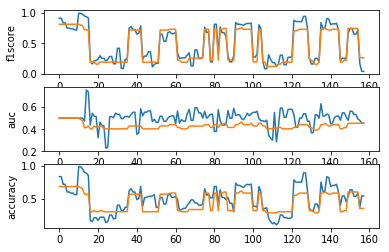

iteration 0
cost 0.692809
 
 
iteration 8
cost 0.693974
 
 
iteration 0
cost 0.694488
 
 
iteration 8
cost 0.692942
 
 
iteration 0
cost 0.697137
 
 
iteration 8
cost 0.692986
 
 
iteration 0
cost 0.692632
 
 
iteration 8
cost 0.694960
 
 
iteration 0
cost 0.693414
 
 
iteration 8
cost 0.693642
 
 
iteration 0
cost 0.687500
 
 
iteration 8
cost 0.681817
 
 
iteration 0
cost 0.694741
 
 
iteration 8
cost 0.696005
 
 
iteration 0
cost 0.690871
 
 
iteration 8
cost 0.688933
 
 
iteration 0
cost 0.690580
 
 
iteration 8
cost 0.690735
 
 
iteration 0
cost 0.692991
 
 
iteration 8
cost 0.693121
 
 
iteration 0
cost 0.690012
 
 
iteration 8
cost 0.687253
 
 
iteration 0
cost 0.691975
 
 
iteration 8
cost 0.687553
 
 
iteration 0
cost 0.691228
 
 
iteration 8
cost 0.693309
 
 
iteration 0
cost 0.695919
 
 
iteration 8
cost 0.693408
 
 
iteration 0
cost 0.693302
 
 
iteration 8
cost 0.692310
 
 
iteration 0
cost 0.692955
 
 
iteration 8
cost 0.694427
 
 
iteration 0
cost 0.693428
 
 
iteration 

In [ ]:
# number of times to iterate over whole training dataset
check_1_time = 1
iter_over_files =  2
for itera in range(0, iter_over_files):
    dir_len = len(file_dir)
    # select file to treat as validation set
    val_file_no = np.random.randint(low=0,high=dir_len)
    val_file = file_dir[val_file_no]
    # train_para and vali_para are storing f1score,auc,accuracy for 
    # train and validation set.
    train_para = []
    vali_para = []
    
    data_thread = Thread(target=data_processing,args=(val_file,))
    data_thread.start()
    data_thread.join()
    # collect validation data in one list to reduce no of parameters
    # to pass between functions
    val_data = [val_file, inde_featuress, sseq_len, target_valuess]
    # reset these so that these can be used in the below call of data_processing
    inde_featuress = []
    sseq_len = []
    target_valuess = []
    # iterate over each file and train
    for file_ in file_dir:
        # do not train on validation file
        if file_ == val_file:
            continue
        data_thread = Thread(target=data_processing,args=(file_,))
        data_thread.start()
        data_thread.join()
        #print "reading data file %s"%file_
        # collect values to form a list to reduce the parameters to be passed
        train_data = [file_, inde_featuress, sseq_len, target_valuess]
        # reset the values to be used in next call of either val or train set
        inde_featuress = []
        sseq_len = []
        target_valuess = []
        
        if 1!=check_1_time:
            tr_ev_thread.join()
#        print thread_inde_features[0].shape
        tr_ev_thread = Thread(target = train_eval, args = \
            (train_data, val_data))
        tr_ev_thread.start()
        check_1_time = 0
        
    tr_ev_thread.join()
    
    t_para = np.asarray(train_para)
    v_para = np.asarray(vali_para)
    
    plot_parameters(t_para, v_para)

In [ ]:
print ('opening file for write')
label = ["IdFeedBack,Prediction"]
with open('output.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ')
    spamwriter.writerow(label)

    for file_ in test_file_dir:
        # get features from current indexed file
        features = get_test_data(file_)        
        # training features is np array with max size and padding
        test_features, seq_len = prepare_data(features, max_seq_len)
        # scale features to have 0 mean and 1 variance
        scaled_features = feature_scaling(test_features, batch_size,\
                seq_len)
        # find independent components from given features
        inde_features = independent_components(scaled_features, batch_size,\
                seq_len)
        # evaluate over whole file
        y = np.zeros(0)
        if "Sess05" in file_:
            indices = ["%03d" %(i+1) for i in range(100)]
    #        print file_
            for index in range(0,100,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)
        else:
            indices = ["%03d" %(i+1) for i in range(60)]
            for index in range(0,60,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)

        for i in xrange(0,y.shape[0]):
            values = [file_[5:-4]+'_FB'+indices[i]+','+str(int(y[i]))]
            spamwriter.writerow(values)
print ('file write complete')